In [171]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [172]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [173]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

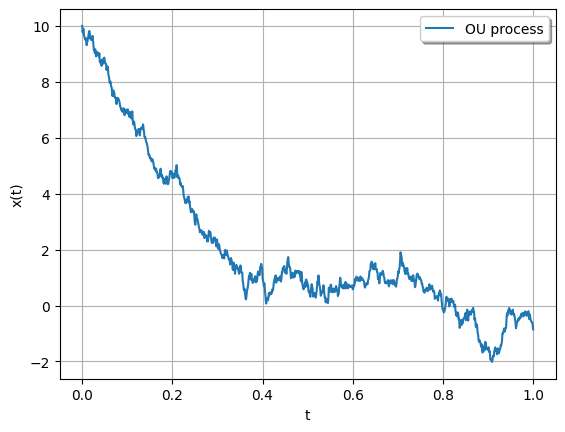

In [174]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

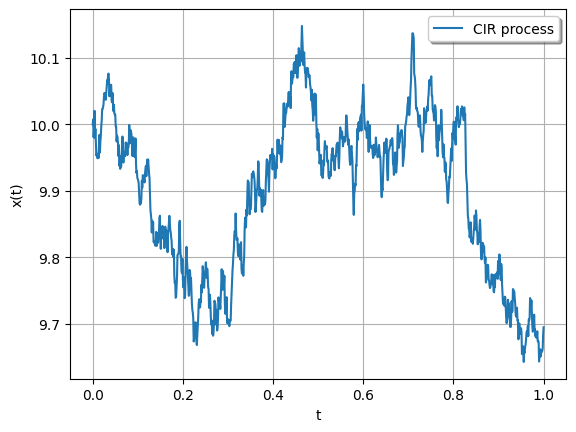

In [175]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

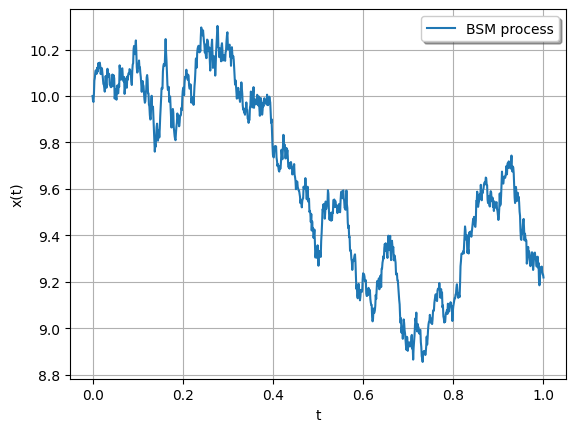

In [176]:
theta1 = 0
theta2 = 0.1
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [177]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


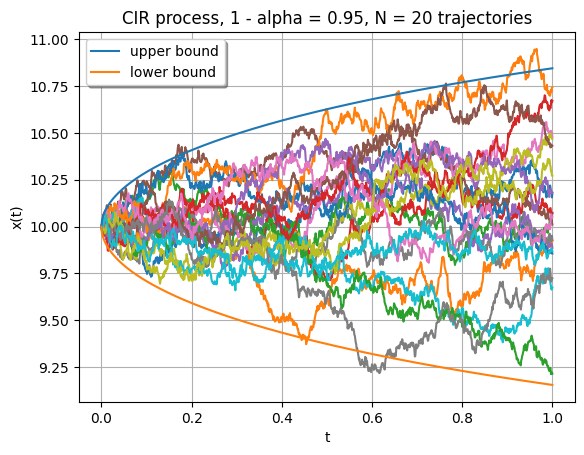

In [178]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


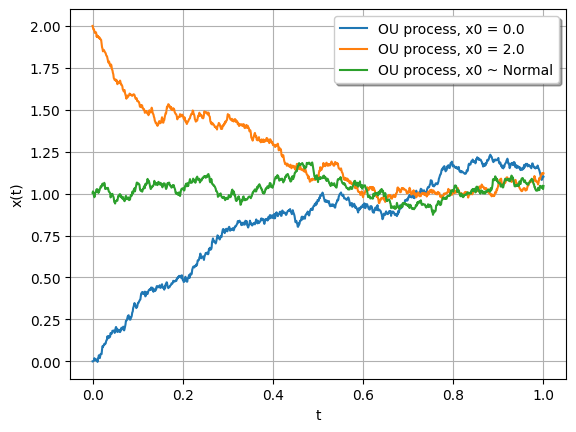

In [179]:
T = 1
Nx = 1
Nt = 1000

theta = 5
mu = 1
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Define a path with the stationary distribution from the graph and prove mathematically.

# Процесс Оорнштейна-Уленбека и стационарное распределение

## 1. Процесс Оорнштейна-Уленбека

Процесс Оорнштейна-Уленбека определяется следующим стохастическим дифференциальным уравнением (СДУ):

$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t,
$$

где:
- $ \theta $ — скорость возвращения к среднему,
- $ \mu $ — долгосрочное среднее,
- $ \sigma $ — волатильность,
- $ W_t $ — процесс Винера.

Для нашего конкретного случая мы имеем параметры:

$$
\theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3.
$$

## 2. Стационарное распределение

Стационарное распределение процесса Оорнштейна-Уленбека является нормальным распределением, заданным следующим образом:

$$
X \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right).
$$

### 2.1 Доказательство

Чтобы вывести это, мы начинаем с того, что стационарное распределение $ p(x) $ должно удовлетворять уравнению Фоккера-Планка, связанному с процессом Оорнштейна-Уленбека. Уравнение Фоккера-Планка для процесса вида 

$$ dX_t = b(X_t)dt + \sigma dW_t $$ 

задается следующим образом:

$$
\frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} [b(x) p] + \frac{1}{2} \frac{\partial^2}{\partial x^2} [\sigma^2 p].
$$

В нашем случае у нас есть:
- Дрейф: $ b(x) = \theta(\mu - x) $
- Коэффициент диффузии: $ \sigma $

При стационарности, $ \frac{\partial p}{\partial t} = 0 $, поэтому мы устанавливаем левую сторону равенства в ноль:

$$
0 = -\frac{\partial}{\partial x} [\theta(\mu - x) p] + \frac{1}{2} \sigma^2 \frac{\partial^2 p}{\partial x^2}.
$$

Решение этого уравнения приводит к стационарному распределению:

$$
p(x) \propto \exp\left(-\frac{(x - \mu)^2}{2\frac{\sigma^2}{2\theta}}\right),
$$

что упрощается до:

$$
p(x) = \frac{1}{\sqrt{\pi \sigma^2/\theta}} \exp\left(-\frac{\theta (x - \mu)^2}{\sigma^2}\right).
$$

Таким образом, мы приходим к выводу:

$$
X \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right).
$$

[Wiki link](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation)

Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts
around $1/2$, generate a path and plot it in graph. Prove your solution.


Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

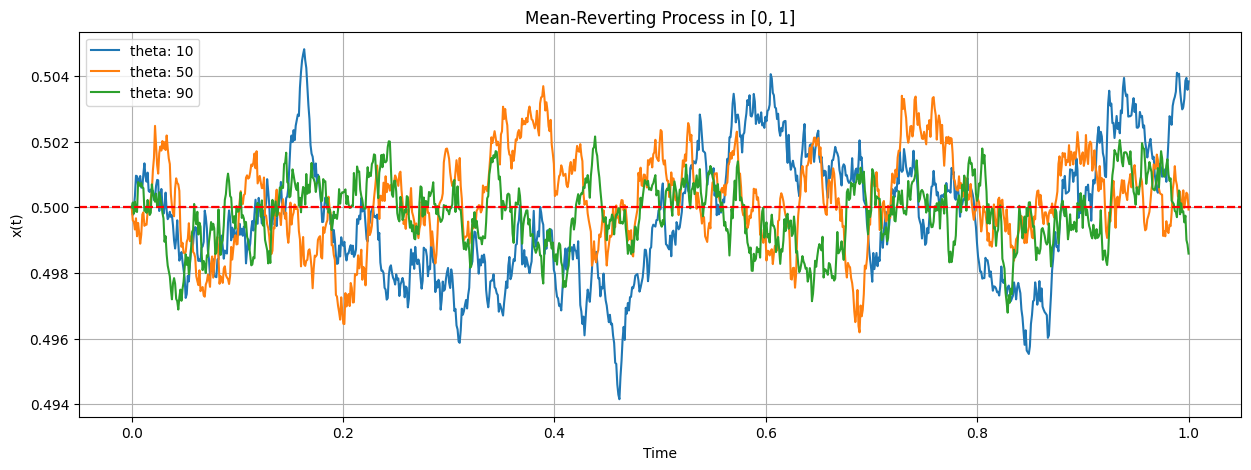

In [180]:
def DesingProcess(theta=0, n=10):
    # Parameters
    T = 1.0        # Total time
    Nt = 1000      # Number of time steps
    # theta = 5.0    # Mean reversion speed
    sigma = 0.05    # Volatility

    # Time discretization
    dt = T / Nt
    t = np.linspace(0, T, Nt)

    # Initial state
    x0 = 0.5  # Starting at the mean
    x_data = np.zeros(Nt)
    x_data[0] = x0

    
    plt.figure(figsize=(15,5))
    for theta in np.arange(10, 100, 40):
        # Simulating the process
        for i in range(1, Nt):
            x_prev = x_data[i - 1]
            drift = theta * (0.5 - x_prev) * dt
            diffusion = sigma * x_prev * (1 - x_prev) * np.sqrt(dt) * np.random.normal()
            x_data[i] = x_prev + drift + diffusion

        # Plotting the result
        plt.plot(t, x_data, label=f'theta: {theta}')
        plt.axhline(y=0.5, color='r', linestyle='--')
        plt.xlabel('Time')
        plt.ylabel('x(t)')
        plt.title('Mean-Reverting Process in [0, 1]')
        plt.legend()
        plt.grid(True)
    plt.show()

DesingProcess()

Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.





1. Modified CIR model
$$dX_t = \theta(\mu - X_t)dt + \sigma \sqrt{X_t} dW_t$$

In [181]:
class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return np.full(self.Nx, self.params[1])


2. Chan-Karolyi-Longstaff-Sanders Family of Models
$$dX_t = \theta(\mu(X_t) - X_t)dt + \sigma(X_t) dW_t$$

In [182]:
class CKLSProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, mu, sigma, alpha]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * x ** self.params[3]

    def sampler_init_state(self):
        return np.full(self.Nx, self.params[1])

3. Nonlinear Mean Reversion Ait-Sahalia Model
$$dX_t = \theta(\mu(X_t) - X_t)dt + \sigma(X_t) dW_t$$

In [183]:
class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x ** 2)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return np.full(self.Nx, self.params[1] ** 0.5)

4. Jacobi Diffusion Process
$$dX_t = \alpha(\beta - X_t)dt + \sigma \sqrt{X_t(1 - X_t)} dW_t$$

In [184]:
class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * (1 - x) * (1 + x)

    def sampler_init_state(self):
        return np.full(self.Nx, self.params[1])

5. Ahn and Gao Model (Inverse of Feller’s Square Root Model)
$$dX_t = \theta(\mu - \sqrt{X_t})dt + \sigma dW_t$$

In [185]:
class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return np.full(self.Nx, self.params[1])

6. Radial Ornstein-Uhlenbeck Process
$$dX_t = -\theta X_t dt + \sigma dW_t$$

In [186]:
class RadialOUProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        # params = [theta, sigma]
        self.bxt = lambda x: -self.params[0] * x
        self.sigmaxt = lambda x: self.params[1]

    def sampler_init_state(self):
        return np.zeros(self.Nx)  # Starting at the origin

### Example of using classes

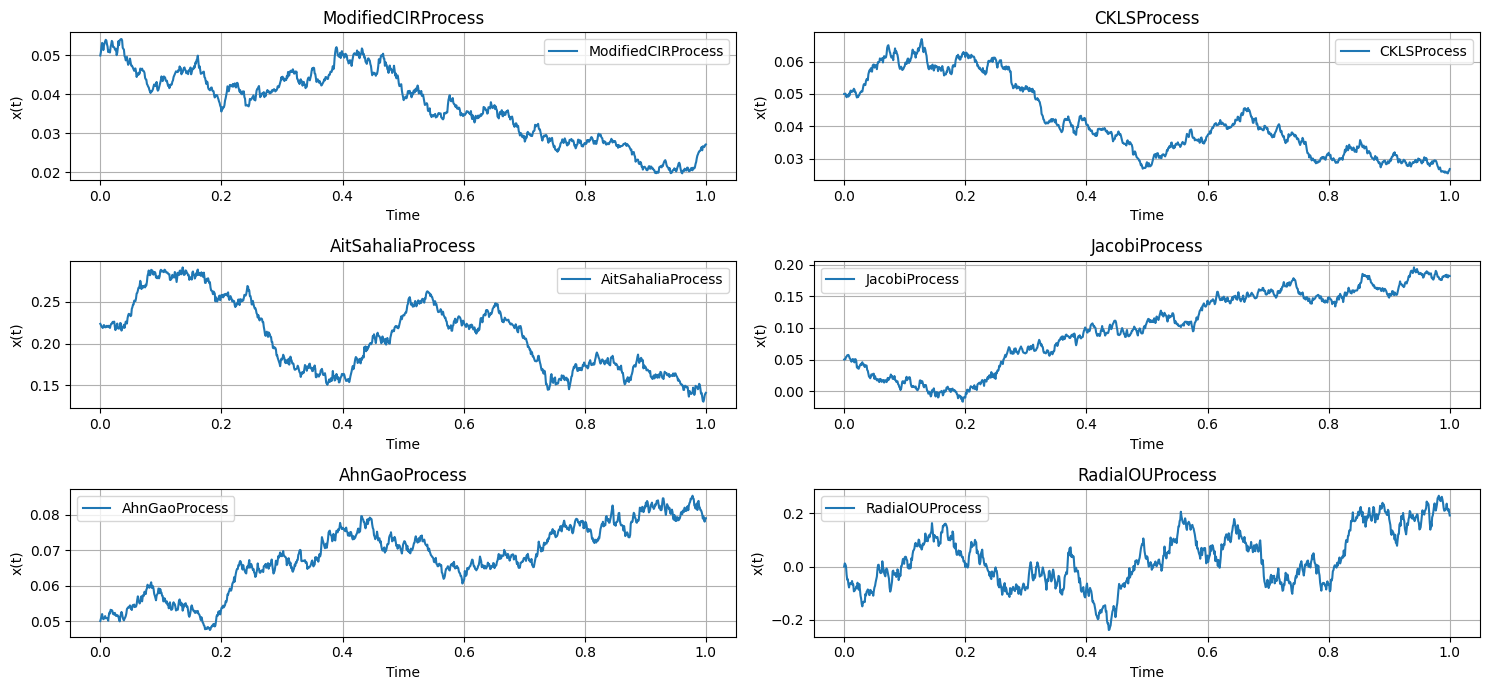

In [187]:
# Common parameters for the models
T = 1.0
Nx = 1
Nt = 1000

# Parameters for each model
params_cir = [0.1, 0.05, 0.1]  # Modified CIR
params_ckls = [0.1, 0.05, 0.1, 0.5]  # CKLS
params_ait = [0.1, 0.05, 0.1]  # Ait-Sahalia
params_jacobi = [0.1, 0.05, 0.1]  # Jacobi
params_ahn = [0.1, 0.05, 0.1]  # Ahn and Gao
params_radial_ou = [15, 0.5]  # Radial OU

# Create instances of each process
processes = [
    ModifiedCIRProcess(params_cir, T, Nx, Nt),
    CKLSProcess(params_ckls, T, Nx, Nt),
    AitSahaliaProcess(params_ait, T, Nx, Nt),
    JacobiProcess(params_jacobi, T, Nx, Nt),
    AhnGaoProcess(params_ahn, T, Nx, Nt),
    RadialOUProcess(params_radial_ou, T, Nx, Nt)
]

# Plotting each process
plt.figure(figsize=(15, 7))

for i, process in enumerate(processes):
    t_data, x_data = process.EulerSolution()
    plt.subplot(3, 2, i + 1)
    plt.plot(t_data, x_data, label=process.__class__.__name__)
    plt.title(process.__class__.__name__)
    plt.xlabel('Time')
    plt.ylabel('x(t)')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

Task 6.

Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

In [221]:
import sympy as sp
from sympy import latex
from IPython.display import display, Math

# Определяем символы
X0, theta, kappa, sigma, t, n = sp.symbols('X0 theta kappa sigma t n')

# Функции A(t) и B(t)
def A(t):
    return sp.exp(-kappa * t) * X0 + theta * (1 - sp.exp(-kappa * t))

def B(t):
    return sigma * sp.exp(-kappa * t)

# Подставляем A(t) и B(t) без конкретных значений параметров
A_t = A(t)
B_t = B(t)

# Функция для вычисления n-го момента
def expected_moment(n):
    moment = 0
    max_j = n // 2  # [n/2]
    
    for j in range(max_j + 1):
        # Вычисляем A(t)^(n-2j) и B(t)^(2j)
        A_term = A_t**(n - 2 * j)
        B_term = B_t**(2 * j)
        
        # Часть с kappa
        kappa_part = (1 / (2 * kappa)) * (sp.exp(2 * kappa * t) - 1)
        kappa_term = kappa_part**(2 * j)
        
        # Суммируем
        moment += A_term * B_term * kappa_term
        
    return moment  # Возвращаем без подстановки значения t и вычисления

# Вычисляем первый и второй моменты
first_moment = expected_moment(1)
second_moment = expected_moment(2)

# Выводим общие аналитические результаты
display(Math(r'\mathbb{E}\{X(t)\} = ' + latex(first_moment)))
display(Math(r'\mathbb{E}\{X^2(t)\} = ' + latex(second_moment)))

# Конкретные значения параметров
kappa_val = 1
theta_val = 0.45
sigma_val = 1
t_val = 1  # Значение для t
X0_val = 0  # Значение для X0

# Подставляем значения параметров
first_moment_value = first_moment.subs({kappa: kappa_val, theta: theta_val, sigma: sigma_val, t: t_val, X0: X0_val}).evalf()
second_moment_value = second_moment.subs({kappa: kappa_val, theta: theta_val, sigma: sigma_val, t: t_val, X0: X0_val}).evalf()

# Выводим конкретные значения
print(f"E{{X(t)}} = {first_moment_value}")
print(f"E{{X^2(t)}} = {second_moment_value}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

E{X(t)} = 0.284454251472851
E{X^2(t)} = 1.46201206672280


### Reinit CIR class

In [223]:
class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, kappa, sigma]
        self.bxt = lambda x: self.params[1] * (self.params[0] - x)  # kappa * (theta - x)
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))  # sigma * sqrt(X)

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def expected_moment(self, n, t):
        # Определяем A(t) и B(t) с учетом параметров
        X0 = self.init_state if self.init_state is not None else self.params[0] / self.params[1]
        A_t = sp.exp(-self.params[1] * t) * X0 + self.params[0] * (1 - sp.exp(-self.params[1] * t))
        B_t = self.params[2] * sp.exp(-self.params[1] * t)
        
        moment = 0
        max_j = n // 2  # [n/2]
        
        for j in range(max_j + 1):
            A_term = A_t**(n - 2 * j)
            B_term = B_t**(2 * j)
            kappa_part = (1 / (2 * self.params[1])) * (sp.exp(2 * self.params[1] * t) - 1)
            kappa_term = kappa_part**(2 * j)
            moment += A_term * B_term * kappa_term
        
        return moment

# Пример использования класса
params = [0.45, 1, 1]  # [theta, kappa, sigma]
T = 1
Nx = 1
Nt = 100
init_state = 0

cir_process = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)

# Вычисление первого и второго моментов в t=1
t_val = 1
first_moment = cir_process.expected_moment(1, t_val)
second_moment = cir_process.expected_moment(2, t_val)

# Выводим результаты
print(f"E{{X(t)}} = {first_moment.evalf()}")
print(f"E{{X^2(t)}} = {second_moment.evalf()}")

print(f"E{{X(t)}} = {first_moment_value}")
print(f"E{{X^2(t)}} = {second_moment_value}")

E{X(t)} = 0.284454251472851
E{X^2(t)} = 1.46201206672280
E{X(t)} = 0.284454251472851
E{X^2(t)} = 1.46201206672280


Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by
$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.

